# Time Series Analysis

Aim: Find insights using the time series with respect to for example:
- engagement rate (per post and follower)
- follower gain

In [28]:
import matplotlib.pyplot as plt
import scipy
from scipy.signal import find_peaks
import pandas as pd
import numpy as np

In [5]:
PATH = "/Users/flohmann/Documents/ETH/FS2024/datathon24/skylab_instagram_datathon_dataset.csv"
df = pd.read_csv(PATH,  sep = ';')

In [6]:
def preprocess_data(df, missing_values_cutoff=0.7, test_fraction=0.2):

    df = df.drop(columns=["period", "calculation_type", "compset", "compset_group", "legal_entity_name", "ultimate_parent_legal_entity_name", "primary_exchange_name"])
    df["period_end_date"] = pd.to_datetime(df["period_end_date"])

    df = df.rename(columns={'business_entity_doing_business_as_name': 'brand', 'period_end_date': 'date'})

    df = df[df['brand'] != "All Brands"]
    df = df[df['brand'] != "Boca"]
    df = df[df['brand'] != "Bulgari Beauty"]

    df = df.groupby(['brand', 'date']).first().reset_index()

    def correct_country_name(name):
        country_map = {
            "Hong Kong": "China",
            "China;Hong Kong": "China",
            ";France": "France",
            ";": None,
            "Belgium;": "Belgium"
        }
        if name in country_map.keys():
            return country_map[name]
        return name

    df['domicile_country_name'] = df['domicile_country_name'].apply(correct_country_name)


    categorical_features = ["domicile_country_name"]
    for feature in categorical_features:
        df = pd.get_dummies(df, columns=[feature], prefix=feature, dummy_na=True, dtype=int)

    # TODO: remove bad data
    na_frac = df[['brand', 'followers', 'pictures',
        'videos', 'comments', 'likes']].groupby('brand').apply(lambda x: x.iloc[:,1:].isna().sum()/len(x))

    bad_brands = list(na_frac[na_frac.max(axis=1) > missing_values_cutoff].index)

    df = df[~df['brand'].isin(bad_brands)]


    # TODO: add additional features
    df['engagement'] = df['comments'] + df['likes']
    df['engagement_rate'] = df['engagement']/df['followers']
    df['engagement_rate_per_post'] =  df['engagement_rate']/(df['videos'] + df['pictures'])


    # # df = video_to_picture_ratio(df, "videos", "pictures")
    # df = calculate_rolling_average_per_brand(df, "brand", window_size=4)
    # df = calculate_exponential_moving_average_per_brand(df, "brand", span=4)
    # # df = calculate_brand_wise_growth_rates(df, ["comments", "likes", "followers", "pictures", "videos"], "brand")
    # for c in ["comments", "likes", "followers", "pictures", "videos"]:
    #     df = calculate_brand_rolling_statistics(df, c, "brand", window_size=4)
    #     df = create_brand_lag_features(df, c, "brand", 4)

    
    # Step 1: Sort the dataframe by time
    df_sorted = df.sort_values(by='date')

    # Step 2: Group the dataframe by 'Brand'
    grouped = df_sorted.groupby('brand')

    # Step 3: Define an empty dataframe for train and test sets
    train_df = pd.DataFrame(columns=df.columns)  # Columns same as original dataframe
    test_df = pd.DataFrame(columns=df.columns)   # Columns same as original dataframe

    # Step 4: Iterate over each group and split into train and test sets
    for _, group in grouped:
        n_rows = len(group)
        n_test = int(test_fraction * n_rows)  # 20% of rows for test set

        # Add last 20% of rows to test set
        test_df = pd.concat([test_df, group.iloc[-n_test:]])

        # Add remaining rows to train set
        train_df = pd.concat([train_df, group.iloc[:-n_test]])

    # Step 5: Reset index for both train and test dataframes
    train_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)


    # TODO: normalize values

    normalize_cols = [c for c in train_df.columns if c not in ['brand', 'date'] and not c.startswith("domicile_country_name")]
    for col in normalize_cols:
        m = train_df[col].mean()
        s = train_df[col].std()
        train_df[col] = (train_df[col] - m)/s
        test_df[col] = (test_df[col] - m)/s


    # TODO: impute missing values
  
    # TODO: impute missing values
    train_df = train_df.groupby('brand').apply(lambda group: group.fillna(method='ffill'))
    train_df = train_df.reset_index(drop=True)

    train_df = train_df.groupby('brand').apply(lambda group: group.fillna(method='bfill'))
    train_df = train_df.reset_index(drop=True)


    test_df = test_df.groupby('brand').apply(lambda group: group.fillna(method='ffill'))
    test_df = test_df.reset_index(drop=True)

    test_df = test_df.groupby('brand').apply(lambda group: group.fillna(method='bfill'))
    test_df = test_df.reset_index(drop=True)



    return train_df, test_df

In [10]:
df_new, df_test = preprocess_data(df) #function from Dave's preprocesing.ipynb

/var/folders/xw/fn_947n13s74lq45rlqjgn780000gn/T/ipykernel_7103/3199848952.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'videos', 'comments', 'likes']].groupby('brand').apply(lambda x: x.iloc[:,1:].isna().sum()/len(x))
/var/folders/xw/fn_947n13s74lq45rlqjgn780000gn/T/ipykernel_7103/3199848952.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_df = pd.concat([test_df, group.iloc[-n_test:]])
/var/folders/xw/fn_947n13s74lq45rlqjgn780000gn/

---------
## Number of Followers

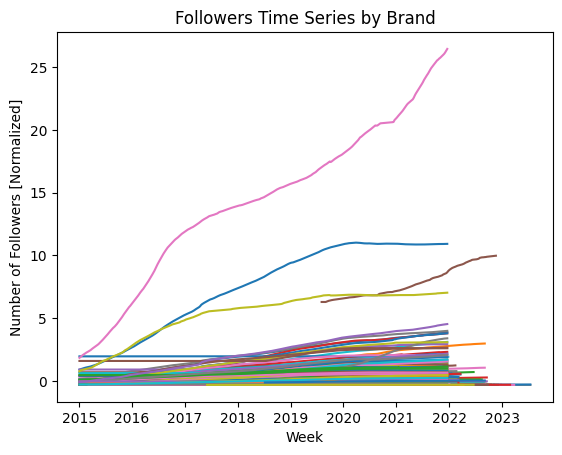

In [11]:
# Convert 'date' column to datetime
df_new['date'] = pd.to_datetime(df_new['date'])

# Group by brand
grouped = df_new.groupby('brand')

# Plot time series for 'followers' for each brand
for brand, group in grouped:
    plt.plot(group['date'], group['followers'], label=brand)

# Add labels and legend
plt.xlabel('Week')
plt.ylabel('Number of Followers [Normalized]')
plt.title('Followers Time Series by Brand')
#plt.legend()
plt.show()

In [12]:
# Find the last date for each brand
last_dates = df_new.groupby('brand')['date'].max().reset_index()

# Merge to get the corresponding rows
last_rows = pd.merge(last_dates, df_new, on=['brand', 'date'], how='inner')

# Sort the rows by the number of followers in descending order
ranked_brands = last_rows.sort_values(by='followers', ascending=False)

# Output the sorted DataFrame
print(ranked_brands[0:10])

                 brand       date  followers  pictures    videos   comments  \
416               Nike 2021-12-18  26.440355 -0.137392  0.146266   0.484726   
10              Adidas 2021-12-18  10.924435  1.073735  1.166862   0.729021   
355             MARVEL 2022-11-19   9.979855  0.679497  6.014694   2.114647   
648  Victoria's Secret 2021-12-18   7.037383  2.579652  1.916363   0.335447   
674               Zara 2021-12-18   4.541323 -0.304322  0.066532  -0.008208   
257                H&M 2021-12-18   3.998932  0.160950 -0.220511   0.191092   
130             Chanel 2021-12-18   3.910284 -0.275908  0.544936   0.255799   
350      Louis Vuitton 2021-12-18   3.807571 -0.325632  0.050585   0.373781   
253              Gucci 2021-12-18   3.803611 -0.286563 -0.140777   0.665864   
517              SHEIN 2021-12-18   3.405638  7.054784  1.629320  10.271575   

         likes  domicile_country_name_Australia  \
416   1.483603                                0   
10    1.428647              

------
## Engagement Rate (per Post and Follower)

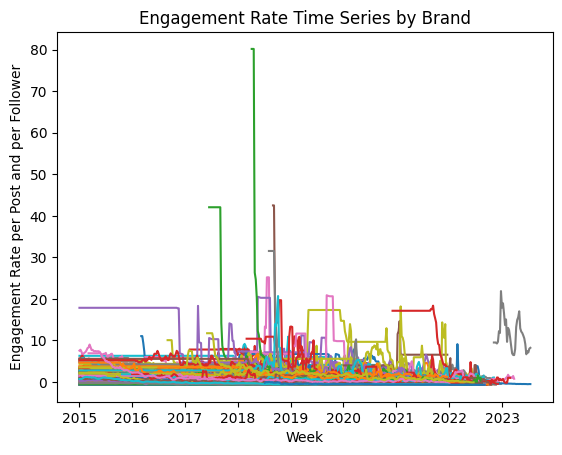

In [13]:
# Plot time series for 'followers' for each brand
for brand, group in grouped:
    plt.plot(group['date'], group['engagement_rate_per_post'], label=brand)

# Add labels and legend
plt.xlabel('Week')
plt.ylabel('Engagement Rate per Post and per Follower')
plt.title('Engagement Rate Time Series by Brand')
#plt.legend()
plt.show()

In [14]:
# Find the last date for each brand
last_dates = df_new.groupby('brand')['date'].max().reset_index()

# Merge to get the corresponding rows
last_rows = pd.merge(last_dates, df_new, on=['brand', 'date'], how='inner')

# Sort the rows by the number of followers in descending order
ranked_brands = last_rows.sort_values(by='engagement_rate_per_post', ascending=False)

# Output the sorted DataFrame
print(ranked_brands[0:10])

                   brand       date  followers  pictures    videos  comments  \
227      Finding Unicorn 2023-07-15  -0.303137 -0.414424 -0.252404 -0.175154   
85        Bottega Veneta 2021-12-18  -0.302349 -0.449941 -0.332139 -0.176534   
498        Richard Mille 2021-12-18  -0.157018 -0.425079 -0.316192 -0.144573   
138             Chipotle 2021-12-18  -0.203120 -0.425079 -0.332139 -0.135441   
284      In-N-Out Burger 2021-12-18  -0.248447 -0.417976 -0.316192 -0.054259   
378             Meow Mix 2022-02-12  -0.302150 -0.449941 -0.316192 -0.176347   
191            Dr Pepper 2021-12-18  -0.251617 -0.432183 -0.332139 -0.162104   
516         Runnerspoint 2021-12-18  -0.299951 -0.449941 -0.332139 -0.176534   
529               Sanrio 2022-08-27  -0.141982 -0.268805 -0.204564  0.002525   
641  Vacheron Constantin 2021-12-18  -0.236150 -0.410873 -0.332139 -0.164574   

        likes  domicile_country_name_Australia  domicile_country_name_Belgium  \
227 -0.260129                         

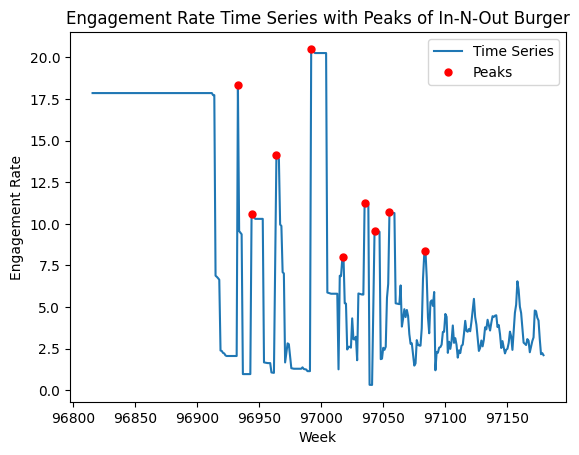

In [15]:
# Example time series data (replace this with your actual data)
time_series = df_new[df_new['brand'] == 'In-N-Out Burger']['engagement_rate_per_post']

# Set the threshold to be 0.1 times the maximum peak height in the time series
threshold = 0.3 * time_series.max()
# Find peaks
peaks, _ = find_peaks(time_series, height=0, prominence=threshold)

# Plot the time series
plt.plot(time_series.index, time_series.values, label='Time Series')

# Plot the peaks
plt.plot(time_series.index[peaks], time_series.values[peaks], 'ro', markersize=5, label='Peaks')

# Add labels and legend
plt.xlabel('Week')
plt.ylabel('Engagement Rate')
plt.title('Engagement Rate Time Series with Peaks of In-N-Out Burger')
plt.legend()
plt.show()

In [48]:
def get_number_peaks(brand: str, df: pd.DataFrame):

    time_series = df[df.brand == brand]['engagement_rate_per_post']

    # Set the threshold to be 0.1 times the maximum peak height in the time series
    threshold = 0.3 * time_series.max()
    # Find peaks
    peaks, _ = find_peaks(time_series, height=0, prominence=threshold)

    return len(peaks)/len(time_series)


def get_outliers(df: pd.DataFrame, q: float):

    if q <= 0 or q > 1:
        raise ValueError()
    
    n_peaks = [get_number_peaks(b, df) for b in df.brand.unique()]

    # get the qth quantile of the peak number
    q_thresh = np.quantile(n_peaks, q)

    anomalies = df_new.brand.unique()[n_peaks > q_thresh]

    return anomalies


Text(0, 0.5, '# brands')

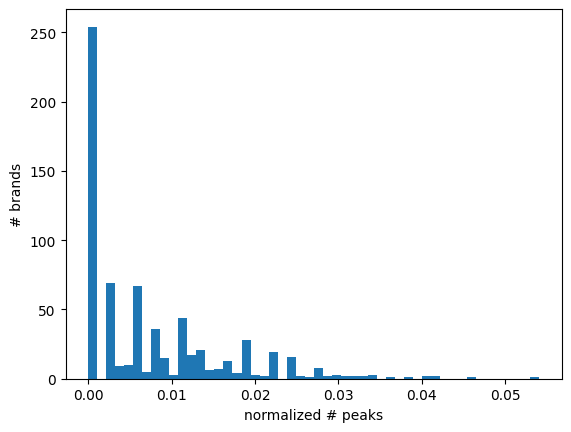

In [39]:
plt.hist(n_peaks, bins = 50)
plt.xlabel('normalized # peaks')
plt.ylabel('# brands')

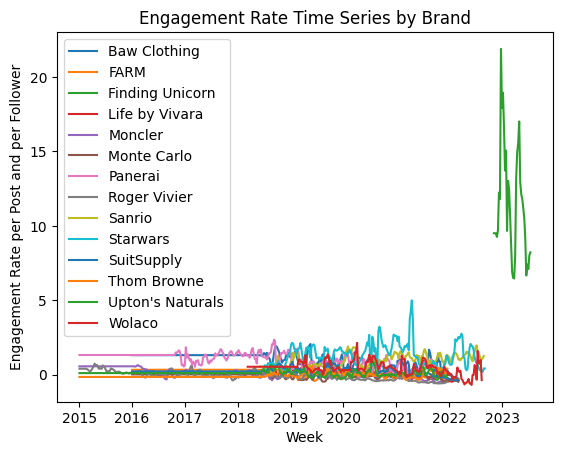

In [47]:
# Plot time series for engagement_rate_per_post for each anomaly brand
for brand, group in df_new[df_new.brand.isin(anomalies)].groupby('brand'):
    plt.plot(group['date'], group['engagement_rate_per_post'], label=brand)

# Add labels and legend
plt.xlabel('Week')
plt.ylabel('Engagement Rate per Post and per Follower')
plt.title('Engagement Rate Time Series by Brand')
plt.legend()
plt.show()